In [106]:
from sentence_transformers import SentenceTransformer

In [8]:
import pymongo
from pymongo import MongoClient

In [9]:
client = MongoClient("localhost", 27017)

In [10]:
#database for tickers
financedb = client["finance_database"]

In [8]:
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'test')

In [3]:
import pandas as pd
import re
from tqdm import tqdm
import os

In [10]:
folder = "/home/notebook/jupyterenv/20061020_20131126_bloomberg_news/"

In [4]:
#function for clearning the data from the datasetand arranging it into dictionaries
def get_struct(filepath):
    try:
        structDict = {"title": "", "author": "", "datetime": "", "source": "", "body": ""}
        fileText = ""
        with open(filepath, 'r') as f:
            for line in f:
                fileText += line

            fileText = re.split("-- |(?<=\.html)\n+", fileText)[1:]
            fileText = [re.sub("\n", " ", val) for val in fileText]
            fileText = [re.sub("\s+", " ", val) for val in fileText]

            for idx, key in enumerate(structDict):
                structDict[key] = fileText[idx]
            
            structDict["text_len"] = get_words_count(structDict["body"])
            
            return structDict
        #if it throws the error, output nothing
    except:
        
        return


In [5]:
#function to get the word count of apiece of text
def get_words_count(text):
    text = text.split(" ")
    return len(text)

In [13]:
#walking through the directory and accumulating the resulted dictionaries in a list
result = []
for subdir, dirs, files in tqdm(sorted(os.walk(folder))):
    dirs.sort()
    for file in sorted(files):
        path = os.path.join(subdir, file)
        if get_struct(path) is None:
            continue
        else:
            result.append(get_struct(path))
    


100%|██████████| 1945/1945 [12:27<00:00,  2.60it/s]


In [30]:
print(result[-13939])

{'title': 'Gilead Stops Leukemia Drug Trial Early on Patient Benefit', 'author': 'B y M e g T i r r e l l', 'datetime': '2013-10-09T21:04:51Z', 'source': 'http://www.bloomberg.com/news/2013-10-09/gilead-stops-leukemia-drug-trial-early-on-patient-benefit.html', 'body': 'Gilead Sciences Inc. (GILD) , the world’s largest biotechnology company by market value, said it isstopping a late-stage study of the cancer drug idelalisib earlybecause of improvement seen in patients taking the drug. Gilead is stopping the study in patients with chroniclymphocytic leukemia after an interim analysis showed thosetaking idelalisib plus another medicine, Rituxan, survivedlonger without their cancer progressing than those takingRituxan alone, the Foster City , California-based company saidtoday in a statement. The trial, from the third and final stage generallyrequired for regulatory approval, was in patients who have triedother medicines and who aren’t fit for chemotherapy. A cancer ofthe bone marrow and w

In [ ]:
#cleaning out the outliers (articles that are to short)
df_result = pd.DataFrame(result)
min_words = int(df_result["text_len"].mean() - df_result["text_len"].std())
df_result = df_result[df_result["text_len"] > min_words]

In [50]:
import yfinance as yf
from datetime import datetime

In [12]:
#tickers that will be used
tickers_used = ["EURUSD=X","GBPUSD=X","CL=F", "GC=F", "^GSPC", "^IXIC", "^DJI"]

In [136]:
#hand made method for converting timestamps to string for every date, however,
#I found a better way of doing it, but it was deleted accidentally
def construct_proper_dict_from_dates(dct):
    return [{"Date": date, "Close_price": val} for date, val in turn_date_to_str(dct).items()]

In [112]:
def turn_date_to_str(dct):
    return {str(date): val for (date,val) in dct.items()}

In [ ]:
#downloading the tickers in the finance db
financedb = client["finance_database"]
for ticker in tickers_used:
    df_ticker = yf.download(ticker, start='2006-10-20', end='2013-11-26', interval = "1d")
    proper_ticker_dict_lst = construct_proper_dict_from_dates(df_ticker["Close"])
    ticker_in_db = financedb[ticker]
    ticker_in_db.insert_many(proper_ticker_dict_lst)

In [145]:
client.list_database_names()

['News', 'admin', 'config', 'finance_database', 'local', 'test']

In [146]:
#tickers are successfully inserted
financedb.list_collection_names()

['^DJI', '^IXIC', 'CL=F', 'GC=F', '^GSPC', 'EURUSD=X', 'GBPUSD=X']

In [1]:
import numpy as np
import pandas as pd

In [13]:
#getting the prices from mongoDB back into dict
coll = financedb[tickers_used[0]]
cur = coll.find()
prices_lst_dct = []
for doc in cur:
    prices_lst_dct.append(doc)


In [14]:
len(prices_lst_dct)

1829

In [15]:
df_prices = pd.DataFrame(prices_lst_dct)

In [16]:
df_prices = df_prices.drop('_id', axis=1)

In [18]:
import matplotlib.pyplot as plt
from datetime import datetime

Text(0, 0.5, 'price')

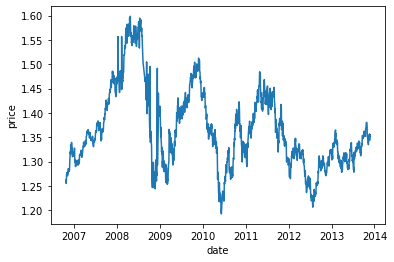

In [20]:
#visualisation of one of the tickers over time
plt.plot(figsize=(2000,1500))
plt.plot([datetime.strptime(date,"%Y-%m-%d %H:%M:%S") for date in df_prices["Date"]], df_prices["Close"])
plt.xlabel("date")
plt.ylabel("price")

In [93]:
df_prices["50_EMA"] = df_prices["Close_price"].ewm(span = 50, min_periods = 1).mean()

In [94]:
df_prices["200_EMA"] = df_prices["Close_price"].ewm(span = 200, min_periods = 1).mean()

In [95]:
df_prices["12_EMA"] = df_prices["Close_price"].ewm(span = 12, min_periods = 1).mean()

In [96]:
df_prices["26_EMA"] = df_prices["Close_price"].ewm(span = 26, min_periods = 1).mean()

In [97]:
df_prices.head()

,Date,Close_price,50_EMA,200_EMA,12_EMA,26_EMA
0,2006-10-20 00:00:00,1.261607,1.261607,1.261607,1.261607,1.261607
1,2006-10-23 00:00:00,1.255099,1.258288,1.258337,1.258082,1.258228
2,2006-10-24 00:00:00,1.255903,1.257461,1.257517,1.257231,1.257392
3,2006-10-25 00:00:00,1.261607,1.258560,1.258555,1.258612,1.258571
4,2006-10-26 00:00:00,1.269406,1.260906,1.260769,1.261545,1.261083


In [21]:
#function to get a double of an expoinenetial moving average
def dema(data, timeframe, column):
    EMA = data[column].ewm(span=timeframe, min_periods=1).mean()
    DEMA = 2*EMA - EMA.ewm(span=timeframe, min_periods=1).mean()
    return DEMA

In [23]:
df_prices['DEMA_12'] = dema(df_prices, 12, 'Close')
df_prices['DEMA_26'] = dema(df_prices, 26, 'Close')

In [27]:
df_prices['Signal'] = 0.0
df_prices['Signal'] = np.where(df_prices['DEMA_12'] > df_prices['DEMA_26'], 1.0, 0.0)
df_prices['Position'] = df_prices['Signal'].diff()

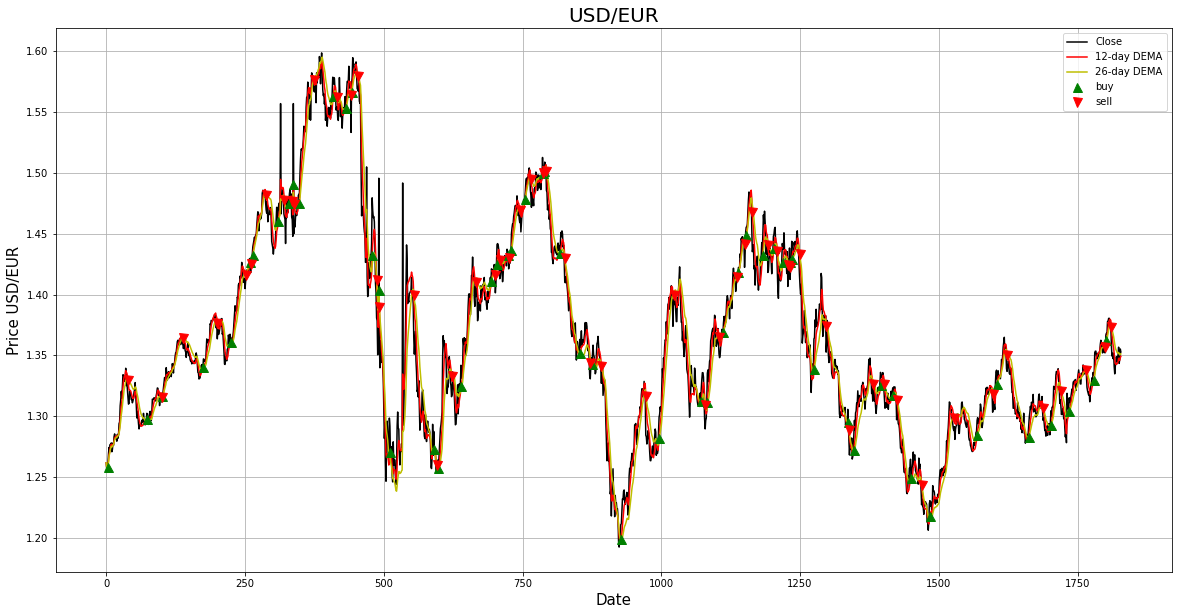

In [28]:
plt.figure(figsize = (20,10))
# plot close price, short-term and long
df_prices['Close'].plot(color = 'k', label= 'Close') 
df_prices['DEMA_12'].plot(color = 'r',label = '12-day DEMA') 
df_prices['DEMA_26'].plot(color = 'y',label = '26-day DEMA') 
# plot ‘buy’ signals
plt.plot(df_prices[df_prices['Position'] == 1].index, 
         df_prices['DEMA_12'][df_prices['Position'] == 1], 
         '^', markersize = 9, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(df_prices[df_prices['Position'] == -1].index, 
         df_prices['DEMA_12'][df_prices['Position'] == -1], 
         'v', markersize = 9, color = 'r', label = 'sell')
plt.ylabel('Price USD/EUR', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.title('USD/EUR', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [29]:
import numpy as np
import time
from datetime import datetime, timedelta
pd.options.mode.chained_assignment = None

In [30]:
#function for detecting trends in a given ticker
def trends_for_ticker(ticker, short_term = True):
    
    #get data from mongoDB 
    coll = financedb[ticker]
    df_prices = pd.DataFrame(list(coll.find()))
    
    #short-term trend detection
    if short_term:
        df_prices["DEMA_12"] = dema(df_prices, 12, 'Close')
        df_prices["DEMA_26"] = dema(df_prices, 26, 'Close')
        df_prices['Signal'] = 0.0
        #check whether two DEMA's cross-over, hence, cross-ovver strategy
        df_prices['Signal'] = np.where(df_prices['DEMA_12'] > df_prices['DEMA_26'], 1.0, 0.0)
    
    #long term trend detection
    else:
        df_prices["DEMA_50"] = df_prices["Close"].ewm(span = 50, min_periods = 1).mean()
        df_prices["DEMA_200"] = df_prices["Close"].ewm(span = 200, min_periods = 1).mean()
        df_prices['Signal'] = 0.0
        df_prices['Signal'] = np.where(df_prices['DEMA_50'] > df_prices['DEMA_200'], 1.0, 0.0)
        
    #get the signals
    df_prices['Position'] = df_prices['Signal'].diff()
    #get only the rows that indicate the start of a trend
    trends = df_prices[np.logical_or(df_prices['Position'] == 1, df_prices['Position'] == -1)]
    
    #get start. and end date by shifting the approprioate columns of the df
    trends['Start_Date'] = trends['Date']
    trends['End_Date'] = trends['Start_Date'].shift(-1)
    trends['Close_Start'] = trends['Close']
    trends['Close_End'] = trends['Close'].shift(-1)
    
    #exlude the last element because it's rudimentary
    trends = trends[:-1]
    
    #drop the unneccesary columns
    trends = trends.drop(['_id', 'Low', 'High', 
                          'Close', 'Date', 'Adj Close', 
                          'DEMA_12', 'DEMA_26', 'Signal', 
                          'Volume', 'Open'], axis=1)          
    #get the actual trends
    trends.loc[(trends['Close_Start'] > trends['Close_End']), 'Trend'] = -1
    trends.loc[(trends['Close_Start'] < trends['Close_End']), 'Trend'] = 1
    #convert strings back to datetime
    trends[['Start_Date', 'End_Date']] = trends[['Start_Date', 'End_Date']].apply(pd.to_datetime) 
    
    return trends

In [31]:
print(trends_for_ticker('EURUSD=X'))
#example output

      Position Start_Date   End_Date  Close_Start  Close_End  Trend
3          1.0 2006-10-25 2006-12-14     1.261607   1.315651    1.0
39        -1.0 2006-12-14 2007-02-01     1.315651   1.301897   -1.0
74         1.0 2007-02-01 2007-03-09     1.301897   1.311596    1.0
100       -1.0 2007-03-09 2007-03-12     1.311596   1.318791    1.0
101        1.0 2007-03-12 2007-05-02     1.318791   1.358806    1.0
...        ...        ...        ...          ...        ...    ...
1735       1.0 2013-07-17 2013-08-29     1.315115   1.333493    1.0
1766      -1.0 2013-08-29 2013-09-17     1.333493   1.333796    1.0
1779       1.0 2013-09-17 2013-10-16     1.333796   1.352174    1.0
1799      -1.0 2013-10-16 2013-10-21     1.352174   1.368195    1.0
1802       1.0 2013-10-21 2013-11-01     1.368195   1.357976   -1.0

[111 rows x 6 columns]


In [144]:
df = pd.read_csv('marketgeek-backend/data/tickers/EURUSD=X_trends.csv')
df.head()

,Unnamed: 0,Start_Date,End_Date,Close_Start,Close_End,Position
0,0,2006-10-25 00:00:00,2006-12-14 00:00:00,1.261607,1.315651,1.0
1,1,2006-12-14 00:00:00,2007-02-01 00:00:00,1.315651,1.301897,-1.0
2,2,2007-02-01 00:00:00,2007-03-09 00:00:00,1.301897,1.311596,1.0
3,3,2007-03-09 00:00:00,2007-03-12 00:00:00,1.311596,1.318791,-1.0
4,4,2007-03-12 00:00:00,2007-05-02 00:00:00,1.318791,1.358806,1.0


In [37]:
#convert string format to datetime when getting from db
def convert_datetime(filename, columns):
    df_ticker = pd.read_csv(filename)
    for column in columns:
        df_ticker[column] = pd.to_datetime(df_ticker[column], format="%Y-%m-%d %H:%M:%S")
    return df_ticker

In [38]:
#get news and tickers with their datetimes
df_tickers = convert_datetime('marketgeek-backend/data/tickers/EURUSD=X_trends.csv', ['Start_Date', 'End_Date'])
df_news = convert_datetime("marketgeek-backend/data/news/full_dataset_march16.csv", ['datetime'])

In [32]:
#getting the news in a certain timeframe. important for the function get_all_sim_news
def get_news_in_timeframe(df, date):
    start_point = date - timedelta(days=2)
    end_point = date - timedelta(hours=12)
    timeframe_news = df[np.logical_and(df["datetime"] >= start_point, df['datetime'] <= end_point)]
    timeframe_news['query_date'] = date
    return timeframe_news

In [33]:
#function for getting the co-occurences along with additional data
def get_all_sim_news(news, df_news, df_tickers):
    
    #initializing all the vareiables
    output_dict = {}

    pos_length = 0
    pos_days = timedelta()
    pos_price = 0
    
    neg_length = 0
    neg_days = timedelta()
    neg_price = 0

    for row in df_tickers.iterrows():
        #get news in a certian time frame (-2 days up to -12 hours before current row[1]['Start_Date'])
        news_in_tf = get_news_in_timeframe(df_news, row[1]["Start_Date"])
        sentiment_id = news['sentiment_id']
        topic_id = news['topic_id'] 
        #discard the outliers, otherwise the statistics would be skewed and not representative
        if topic_id != -1 :
            #leave only the news that share the same sentiment and topic id
            sim_news_in_tf = news_in_tf.loc[
            np.logical_and(news_in_tf['sentiment_id'] == sentiment_id,
                           news_in_tf['topic_id'] == topic_id)]
            #drop duplicates, since we do not need multiple counts of one event
            sim_news_in_tf = sim_news_in_tf.drop_duplicates(subset=['query_date'], keep = 'last')
            
            sim_news_in_tf['Trend_Start'], sim_news_in_tf['Trend_End'] = row[1]['Start_Date'], row[1]['End_Date'] 
            sim_news_in_tf['Closing_Start'], sim_news_in_tf['Closing_End'] = row[1]['Close_Start'], row[1]['Close_End']
            
            #if the trend is upward, and selected similar news are not empty, compute additional data along with co-occurences
            if row[1]["Trend"] == 1 and len(sim_news_in_tf) >= 1:
                pos_length += len(sim_news_in_tf)
                pos_days = pos_days + (row[1]['End_Date'] - row[1]['Start_Date'])
                pos_price = pos_price + ((row[1]['Close_End'] - row[1]['Close_Start'])/row[1]['Close_Start'])*100
            #same with negative trend
            elif row[1]["Trend"] == -1 and len(sim_news_in_tf) >= 1:
                neg_length += len(sim_news_in_tf)
                neg_days = neg_days + row[1]['End_Date'] - row[1]['Start_Date']
                neg_price = neg_price + ((row[1]['Close_End'] - row[1]['Close_Start'])/row[1]['Close_Start'])*100

    #finalise the averages for the output json for pos and neg co-occurences
    output_dict["Pos_Cooccurences"] = pos_length
    output_dict["Pos_Avg_Days"] = str(pos_days/pos_length)
    output_dict["Pos_Avg_Change"] = pos_price/pos_length
    
    output_dict["Neg_Cooccurences"] = neg_length
    output_dict["Neg_Avg_Days"] = str(neg_days/neg_length)
    output_dict["Neg_Avg_Change"] = neg_price/neg_length
    
    return output_dict

In [411]:
import json
import re

In [470]:
#get the final json with all needed data 
def get_tickers_json(news, df_news):
    output_json = {}
    dict_ticker = {}
    output_json['title'] = news['title']
    output_json['author'] = news['author']
    output_json['datetime'] = str(news['datetime'])
    output_json['source'] = news['source']
    output_json['body'] = news['body']
    output_json['sentiment_id'] = int(news['sentiment_id'])
    topics = news['topics']
    topics = re.sub("[^a-zA-Z0-9,]", "", topics)
    topics = topics.split(',')
    output_json['topics'] = topics
    for ticker in tickers_used:
        trends_df = trends_for_ticker(ticker)
        dict_ticker[ticker] = get_all_sim_news(news, df_news, trends_df)
    #sort by pos co-occurences (ideal scenario is detailed in the. evaluation section of the report)  
    dict_ticker = sorted(dict_ticker.items(), key=lambda x: x[1]['Pos_Cooccurences'], reverse=True)
    output_json['data'] = dict_ticker
    json_object = json.dumps(output_json, indent=4)
    
    return json_object

In [466]:
from tqdm import tqdm

In [471]:
#save to a json file with 5 manually selected news
news_articles = [df_news.iloc[255000], df_news.iloc[322166], 
                 df_news.iloc[324166], df_news.iloc[325156], df_news.iloc[360156]]
f = open('news.json', 'w')
for news in tqdm(news_articles):   
    data = get_tickers_json(news, df_news)
    f.write(data)
    f.write("\n")
f.close()

100%|██████████| 5/5 [00:23<00:00,  4.64s/it]
